In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from spacy.matcher import Matcher
import locationtagger
import nltk
nltk.download('punkt')
from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/Anahata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:


# Specify the directory where your JSON files are located
directory = "/Users/Anahata/Desktop/Git/datasets-sotu/data"

# Use os.listdir() to get a list of all files in the directory
file_list = os.listdir(directory)

# Filter the list to include only JSON files
json_files = [file for file in file_list if file.endswith('.json')]

# Create an empty list to store the parsed JSON data from each file
json_data_list = []

# Iterate over the list of JSON files and read and parse their content
for json_file in json_files:
    file_path = os.path.join(directory, json_file)
    with open(file_path, 'r') as file:
        try:
            file_content = json.load(file)
            json_data_list.append(file_content)
        except json.JSONDecodeError as e:
            print(f"Error reading JSON file {json_file}: {e}")
            continue

# Now you have a list of parsed JSON data from the valid JSON files
for i, json_data in enumerate(json_data_list):
    print(f"Contents of JSON file {json_files[i]}:")
    print(json_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:

# Get the total number of dictionaries
total_dictionaries = len(json_data_list)
print(f"Total number of dictionaries: {total_dictionaries}")

Total number of dictionaries: 235


In [4]:
# Iterate over the list of dictionaries
for json_dict in json_data_list:
    # Check if the 'year' key exists in the dictionary and has the value '2000'
    if 'year' in json_dict and json_dict['year'] == 2023:
        desired_dict = json_dict
        break  # Exit the loop once a matching dictionary is found

# Check if a matching dictionary was found
if desired_dict is not None:
    print("Dictionary with 'year' equal to 2023:")
    print(desired_dict)
else:
    print("No dictionary with 'year' equal to 2023 was found.")

Dictionary with 'year' equal to 2023:
{'year': 2023, 'name': 'Joseph R Biden', 'party': 'Democratic', 'text': " Thank you. You can smile. It's okay. Thank you, thank you, thank you. Thank you. Please. Mr. Speaker, Madam Vice President, our First Lady and Second Gentleman—good to see you guys up there—[applause]—Members of Congress. and by the way, Chief Justice, I may need a court order. She gets to go to the game tomorrow—next week. I have to stay home. [Laughter] We've got to work something out here. Members of the Cabinet, leaders of our military, Chief Justice, Associate Justices, and retired Justices of the Supreme Court, and to you, my fellow Americans- You know, I start tonight by congratulating the 118th Congress and the new Speaker of the House, Kevin McCarthy. Speaker, I don't want to ruin your reputation, but I look forward to working with you. [Laughter] And I want to congratulate the new leader of the House Democrats, the first African American minority leader in history, 

In [5]:
df = pd.DataFrame(json_data_list)

In [6]:
df.head()

,year,name,party,text
0,1954,Dwight D Eisenhower,Republican,"Mr. President, Mr. Speaker, Members of the Eig..."
1,1905,Theodore Roosevelt,Republican,To the Senate and House of Representatives: Th...
2,1981,Jimmy Carter,Democratic,To the Congress of the United States: The Stat...
3,1968,Lyndon B Johnson,Democratic,"Mr. Speaker, Mr. President, Members of the Co..."
4,1934,Franklin D Roosevelt,Democratic,"Mr. President, Mr. Speaker, Senators and Repre..."


In [7]:
df = df.sort_values(by=['year'])

In [8]:
df['word_count'] =  df['text'].apply(lambda x: len(x.split()))

In [9]:
df2 = df[['year', 'name', 'party', 'word_count']]
df2.head()

,year,name,party,word_count
167,1790,George Washington,none,1400
186,1791,George Washington,none,2301
107,1792,George Washington,none,2096
28,1793,George Washington,none,1963
159,1794,George Washington,none,2913


In [196]:
df2.to_excel("speech_length.xlsx", index=False) 

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

[Text(0.5, 1.0, 'Word count over time')]

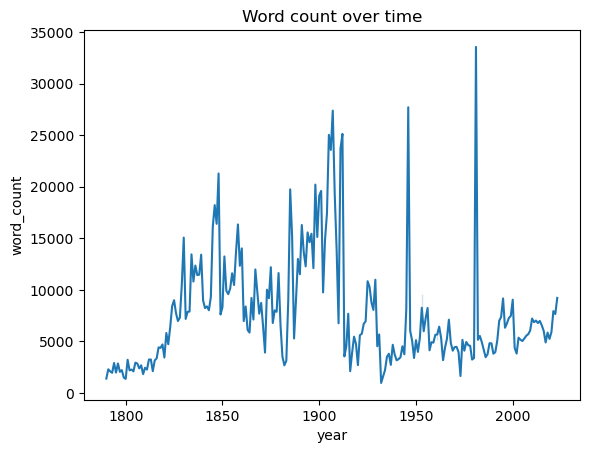

In [10]:
# year vs length
word_count = sns.lineplot(data = df, x = "year", y = "word_count")
word_count.set(title = 'Word count over time')

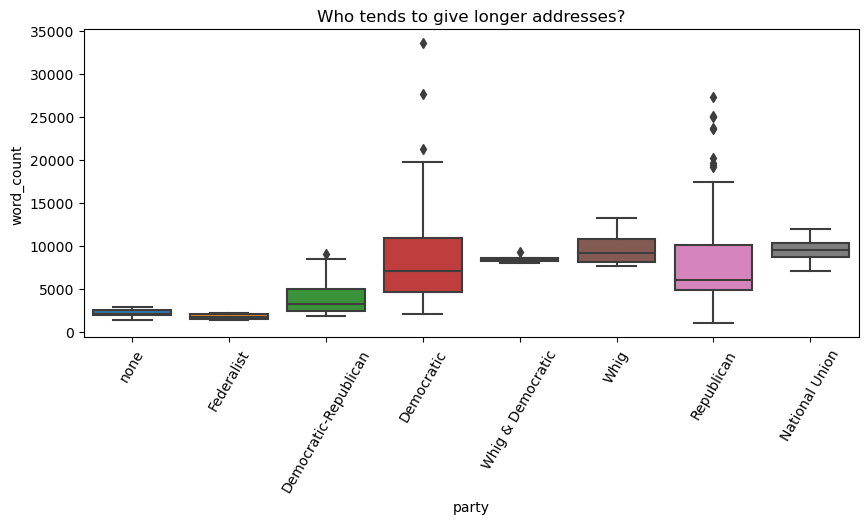

In [132]:
#Presidents from which party tend to speak more?

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x="party",
         y="word_count",
                data=df, ax=ax)
plt.xticks(rotation=60)
plt.title("Who tends to give longer addresses?")
plt.show()    

In [11]:
def clean_string(string):
    string = re.sub(r'[^a-zA-Z]',' ',string)
    string = string.lstrip()
    string = string.rstrip()
    string = " ".join(string.split())
    return string 

In [12]:
df['clean_string'] = df['text'].apply(lambda x: clean_string(x))

In [13]:
stop_words = set(stopwords.words('english'))
stop_words = list(stop_words)

In [14]:
#additional stop words for this case

add_stop_words=['Senate', 'Fellow','okay','Citizens', 'Members', 'citizens','America', 'Congress', 'Speaker', 'House', 'Representatives', 'election',
               'American', 'Thank you', 'Thank', 'thank', 'Madam', 'Vice', 'President', 'please', 'Mr']

In [15]:
all_stop_words = stop_words + add_stop_words
all_stop_words

['him',
 'over',
 "hadn't",
 'which',
 'where',
 'or',
 'off',
 'what',
 'at',
 'by',
 'few',
 'will',
 "haven't",
 'in',
 'nor',
 'i',
 'needn',
 'here',
 'while',
 'a',
 'o',
 'own',
 "mightn't",
 'an',
 "you've",
 'has',
 'be',
 'very',
 'the',
 'doing',
 'yours',
 'yourselves',
 'most',
 "doesn't",
 'any',
 'about',
 'doesn',
 'aren',
 'were',
 'on',
 'had',
 'not',
 'too',
 'again',
 'ain',
 'didn',
 'his',
 'she',
 'above',
 'mustn',
 "you'd",
 'to',
 "don't",
 'shan',
 'our',
 'wasn',
 'so',
 'do',
 'down',
 'themselves',
 'ourselves',
 't',
 'y',
 'itself',
 'there',
 'you',
 'can',
 'just',
 'but',
 'below',
 'ma',
 'for',
 'this',
 'couldn',
 'll',
 'won',
 'they',
 'after',
 'then',
 'both',
 'm',
 'each',
 'more',
 'hadn',
 'them',
 'are',
 'am',
 "isn't",
 "won't",
 'myself',
 'all',
 'is',
 'up',
 'from',
 'himself',
 'their',
 'than',
 "mustn't",
 'that',
 'once',
 'with',
 'my',
 "it's",
 'herself',
 'having',
 'further',
 'as',
 'weren',
 'yourself',
 "wouldn't",
 'her

In [16]:
#function to check for stopwords

def identify_stopwords(string):
    word_tokens = word_tokenize(string)
    filtered_text = [w for w in word_tokens if not w.lower() in all_stop_words]
    filtered_text = []
    for w in word_tokens:
        if w not in all_stop_words:
            filtered_text.append(w)
    
    return filtered_text

In [17]:
abc = "Hello today is a great day thank you see you soon"
identify_stopwords(abc)

['Hello', 'today', 'great', 'day', 'see', 'soon']

In [18]:
df['text_no_stopwords'] = df['clean_string'].apply(lambda x: identify_stopwords(x))

In [19]:
df

,year,name,party,text,word_count,clean_string,text_no_stopwords
167,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl..."
186,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti..."
107,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present..."
28,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,..."
159,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave..."
...,...,...,...,...,...,...,...
232,2019,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5249,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, American..."
76,2020,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5917,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, Three, y..."
98,2021,Joseph R Biden,Democratic,Thank you. (Applause.) Thank you. Thank you. G...,7945,Thank you Applause Thank you Thank you Good to...,"[Applause, Good, back, And, Mitch, Chuck, unde..."
209,2022,Joseph R Biden,Democratic,"Thank you all very, very much. Thank you, plea...",7661,Thank you all very very much Thank you please ...,"[much, much, First, Lady, Second, Gentleman, C..."


In [21]:
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(string):
    lemmatized = [[lemmatizer.lemmatize(word) for word in word_tokenize(s)]
              for s in string]
    return lemmatized


df['lemmatized_words'] = df['text_no_stopwords'].apply(lambda x: lemmatize_text(x))

df.head()


,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words
167,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf..."
186,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi..."
107,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet..."
28,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called..."
159,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen..."


In [22]:
#flatten the list
def flatten(l):
    return [item for sublist in l for item in sublist]

In [23]:
df['lemmatized_words2'] =  df['lemmatized_words'].apply(lambda x: flatten(x))
df.head()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2
167,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf...","[In, meeting, I, feel, much, satisfaction, abl..."
186,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi...","[In, vain, may, expect, peace, Indians, fronti..."
107,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet...","[It, abatement, satisfaction, I, meet, present..."
28,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called...","[Since, commencement, term, I, called, office,..."
159,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen...","[When, call, mind, gracious, indulgence, Heave..."


In [21]:
nlp = spacy.load("en_core_web_sm")

def extract_countries(text):
    doc = nlp(text)  # Process the text using spaCy
    countries = [ent.text for ent in doc.ents if ent.label_ == "GPE"]  # Filter entities labeled as "GPE" (countries)
    return countries
  
df['countries_mentioned'] = df['clean_string'].apply(lambda x: extract_countries(x))

df.head()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned
167,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf...","[In, meeting, I, feel, much, satisfaction, abl...","[Holland, Kentucky, Virginia, Kentucky, Wabash..."
186,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi...","[In, vain, may, expect, peace, Indians, fronti...","[the United States, the United States, the Uni..."
107,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet...","[It, abatement, satisfaction, I, meet, present...","[Ohio, the United States, the United States, t..."
28,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called...","[Since, commencement, term, I, called, office,...","[the United States, the United States, France,..."
159,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen...","[When, call, mind, gracious, indulgence, Heave...","[the United States, States, Pennsylvania, Penn..."


In [24]:
df.tail()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2
232,2019,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5249,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, American...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, American..."
76,2020,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5917,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, Three, y...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, Three, y..."
98,2021,Joseph R Biden,Democratic,Thank you. (Applause.) Thank you. Thank you. G...,7945,Thank you Applause Thank you Thank you Good to...,"[Applause, Good, back, And, Mitch, Chuck, unde...","[[Applause], [Good], [back], [And], [Mitch], [...","[Applause, Good, back, And, Mitch, Chuck, unde..."
209,2022,Joseph R Biden,Democratic,"Thank you all very, very much. Thank you, plea...",7661,Thank you all very very much Thank you please ...,"[much, much, First, Lady, Second, Gentleman, C...","[[much], [much], [First], [Lady], [Second], [G...","[much, much, First, Lady, Second, Gentleman, C..."
67,2023,Joseph R Biden,Democratic,Thank you. You can smile. It's okay. Thank yo...,9223,Thank you You can smile It s okay Thank you th...,"[You, smile, It, Please, First, Lady, Second, ...","[[You], [smile], [It], [Please], [First], [Lad...","[You, smile, It, Please, First, Lady, Second, ..."


_COUNTRY AND STATE ANALYSIS_

In [39]:
# Explode the 'countries_mentioned' column to create separate rows for each country
df2 = df.explode('countries_mentioned')

# Group by 'year' and 'countries_mentioned' and count occurrences
country_mentions_by_year = df2.groupby(['year', 'countries_mentioned']).size().reset_index(name='count')

# Pivot the table to have years as columns and countries as rows
country_mentions_pivot = country_mentions_by_year.pivot(index='countries_mentioned', columns='year', values='count').fillna(0)

# Reset the index and fill NaN values with 0
country_mentions_pivot = country_mentions_pivot.reset_index()


In [40]:
country_mentions_pivot.head()

year,countries_mentioned,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acapulco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,3.0,1.0,0.0,1.0,3.0,3.0,6.0,3.0,0.0
3,Africa the,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Define a mapping to combine similar country names
country_mapping = {
    'united states': 'USA',
    'United States of America': 'USA',
    'US': 'USA',
    'USA' : 'USA',
    'the United States': 'USA',
    'The United States': 'USA',
     'America': 'USA',
    'this Republic of the United States of America' :'USA',
    'united States' : 'USA',
    'States' : 'USA',
    'THE UNITED STATES' : 'USA',
    'The U S' : 'USA',
    'The United States' : 'USA',
    'The United States of America' : 'USA',
    'U S' : 'USA',
    'us' : 'USA',
    'Havana' : 'Cuba',
    'American Republic' : 'USA',
    'Argentine Republic' : 'Argentina',
    'The Soviet Union' :'USSR/Russia',
    'Russia' : 'USSR/Russia',
    'Republic of Russia' : 'USSR/Russia',
    'the Empire of Russia' : 'USSR/Russia',
    'the Russian Empire': 'USSR/Russia',
    'the Russian Federation' : 'USSR/Russia',
    'the Russian State' : 'USSR/Russia',
    'Santiago de Cuba' : 'Cuba',
    'the tepublic of cuba' : 'Cuba',
    'Venezuela' :'Venezuela', 
    'the Republic of Venezuela' : 'Venezuela',
    'the Islamic Republic of Iran' : 'Iran',
    'Tehran' : 'Iran',
    'Ukraine NATO' : 'Ukraine',
    'Ukraine Putin' : 'Ukraine',
    'Asiatic Turkey' : 'Turkey',
    'TURKEY' : 'Turkey',
    'Turkestan' : 'Turkey', 
    'the Sultan of Turkey': 'Turkey',
    'the Turkish Empire' :'Turkey',
    'the Empire of China' : 'China',
    'the People s Republic of China' : 'China',
    'the Republic of China' : 'China'
}

country_mentions_pivot['Unified_Country'] = country_mentions_pivot['countries_mentioned'].map(country_mapping).fillna(country_mentions_pivot['countries_mentioned'])

country_mentions_pivot['Unified_Country'] = country_mentions_pivot['Unified_Country'].str.lower()

country_mentions_pivot

year,countries_mentioned,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unified_Country
0,Aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aana
1,Acapulco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acapulco
2,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,3.0,3.0,6.0,3.0,0.0,afghanistan
3,Africa the,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,africa the
4,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,agriculture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,this Republic of the United States of America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,usa
1265,truly united,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,truly united
1266,united States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,usa
1267,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,usa


In [65]:
country_mentions_pivot.drop(['countries_mentioned'], axis=1, inplace=True)

In [66]:
countries_grouped = country_mentions_pivot.groupby('Unified_Country').sum().reset_index()
countries_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Columns: 233 entries, Unified_Country to 2023
dtypes: float64(232), object(1)
memory usage: 2.1+ MB


In [68]:
#mapping round 2

cols = list(country_mentions_pivot.columns)
cols = [cols[-1]] + cols[:-1]  

# Reorder the DataFrame columns
country_mentions_pivot = country_mentions_pivot[cols]
country_mentions_pivot.head()

year,Unified_Country,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acapulco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,3.0,1.0,0.0,1.0,3.0,3.0,6.0,3.0,0.0
3,africa the,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
country_mapping2 = {
    'the united states' : 'usa',
    'these united states' : 'usa',
    'these united states of america' : 'usa',
    'gaza' : 'palestine',
    'the west bank' : 'palestine',
    'ho chi minh ville' : 'vietnam',
    'hanoi' : 'vietnam',
    'istanbul' : 'turkey',
    'tokyo' : 'japan',
    'ramallah' : 'palestine',
    'hiroshima' : 'japan',
    'kingdom of spain' :'spain',
    'the mexican republic' : 'mexico',
    'the mexican states' : 'mexico',
    'the mexican states of chihuahua' : 'mexico',
    'the presidents of mexico' : 'mexico',
    'the republic of mexico' : 'mexico',
    'the republic of mexico deeply': 'mexico',
    'the united republics of mexico' : 'mexico',
    'mexico city' : 'mexico',
    'the city of mexico' : 'mexico',
    'ottawa' : 'canada',
    'the philippine islands' : 'philippines',
    'north germany' : 'germany',
    'to germany of' : 'germany',
    'the german emperor': 'germany',
    'west germany' :'germany',
    'the german empire' :'germany',
    'the german empire great' : 'germany',
    'the states of germany' : 'germany',
    'the states of the empire of germany' : 'germany',
    'the free republic of germany' : 'germany',
    'the united kingdom' : 'uk',
    'the united kingdom of great britain' : 'uk',
    'england' : 'uk',
    'jerusalem' : 'israel'   
}


country_mentions_pivot['Unified_Country2'] = country_mentions_pivot['Unified_Country'].map(country_mapping2).fillna(country_mentions_pivot['Unified_Country'])

country_mentions_pivot['Unified_Country2'] = country_mentions_pivot['Unified_Country2'].str.lower()

country_mentions_pivot.head()

/var/folders/07/8ng8f7q11l10nz1xwnk4zwv00000gn/T/ipykernel_6041/3516877496.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_mentions_pivot['Unified_Country2'] = country_mentions_pivot['Unified_Country'].map(country_mapping2).fillna(country_mentions_pivot['Unified_Country'])
/var/folders/07/8ng8f7q11l10nz1xwnk4zwv00000gn/T/ipykernel_6041/3516877496.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_mentions_pivot['Unified_Country2'] = country_mentions_pivot['Unified_Country2'].str.lower

year,Unified_Country,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unified_Country2
0,aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aana
1,acapulco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acapulco
2,afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,3.0,3.0,6.0,3.0,0.0,afghanistan
3,africa the,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,africa the
4,agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,agriculture


In [72]:
country_mentions_pivot.drop(['Unified_Country'], axis=1, inplace=True)

cols = list(country_mentions_pivot.columns)
cols = [cols[-1]] + cols[:-1]  

# Reorder the DataFrame columns
country_mentions_pivot = country_mentions_pivot[cols]
country_mentions_pivot.head()

year,Unified_Country2,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acapulco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,3.0,1.0,0.0,1.0,3.0,3.0,6.0,3.0,0.0
3,africa the,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
country_mentions_pivot2 = country_mentions_pivot.groupby('Unified_Country2').sum().reset_index()
country_mentions_pivot2.head()

year,Unified_Country2,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,a federal republic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a province of mexico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,a united states,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a united states of america,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
country_mentions_pivot2.to_excel("country_mentions.xlsx", index=False) 

In [87]:
#mapping round 3

country_mapping3 = {
    'a province of mexico' : 'mexico',
    'a united states' : 'usa',
    'a united states of america' : 'usa',
    'american empire': 'usa',
    'an american republic': 'usa',
    'austria': 'austria',
    'austria hungary' : 'austria',
    'baghdad' : 'iraq',
    'beirut': 'lebanon',
    'beirut kuwait' : 'lebanon',
    'chinese empire' : 'china',
    'east germany' : 'germany',
    'berne switzerland': 'switzerland',
    'berne' : 'switzerland',
    'cairo' : 'egypt',
    'doha' : 'qatar',
    'damascus' : 'syria',
    'every iraqi province' : 'iraq',
    'german states' : 'germany',
    'germanic states': 'germany',
    'the soviet union' : 'ussr/russia',
    'paris' : 'france',
    'london' : 'uk',
    'porto rico' : 'puerto rico',
    'manila' : 'philippines',
    'the argentine republic' : 'argentina',
    'britain' : 'uk',
    'tripoli' : 'libya',
    'caracas' : 'venezuela',
    'the state of nicaragua' : 'nicaragua',
    'seoul' : 'korea',
    'moscow' : 'ussr/russia',
    'holland' : 'netherlands'   
}


country_mentions_pivot2['Unified_Country3'] = country_mentions_pivot2['Unified_Country2'].map(country_mapping3).fillna(country_mentions_pivot2['Unified_Country2'])

country_mentions_pivot2['Unified_Country3'] = country_mentions_pivot2['Unified_Country3'].str.lower()

country_mentions_pivot2.head()

year,Unified_Country2,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unified_Country3
0,a federal republic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a federal republic
1,a province of mexico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mexico
2,a united states,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,usa
3,a united states of america,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,usa
4,aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aana


In [88]:
country_mentions_pivot2.drop(['Unified_Country2'], axis=1, inplace=True)

cols = list(country_mentions_pivot2.columns)
cols = [cols[-1]] + cols[:-1]  

# Reorder the DataFrame columns
country_mentions_pivot2 = country_mentions_pivot2[cols]
country_mentions_pivot2.head()

year,Unified_Country3,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,a federal republic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mexico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,usa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,usa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
countries_grouped2 = country_mentions_pivot2.groupby('Unified_Country3').sum().reset_index()
countries_grouped2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Columns: 233 entries, Unified_Country3 to 2023
dtypes: float64(232), object(1)
memory usage: 2.0+ MB


In [101]:
countries_grouped2['Unified_Country3'] = countries_grouped2['Unified_Country3'].str.upper()
countries_grouped2.rename({'Unified_Country3' : 'Country'}, axis=1, inplace=True)

In [102]:
countries_grouped2.to_excel("country_mentions.xlsx", index=False) 

In [98]:
countries_grouped2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1143 entries, 0 to Total
Columns: 233 entries, Unified_Country3 to 2023
dtypes: float64(232), object(1)
memory usage: 2.0+ MB


In [89]:
country_mentions_pivot2.to_excel("country_mentions.xlsx", index=False) 

_**************************Word Frequency*****************************_

In [31]:
#analyzing the health of the economy- how frequently was each word used in the speech and what was it as a % of total words

# def word_count_and_percentage(row, word):
#     word_occurrence = row['lemmatized_words2'].count(word)
#     total_words = len(row['lemmatized_words2'])  # Count total words in the row
#     word_percentage = (word_occurrence / total_words) * 100 if total_words > 0 else 0
#     return word_occurrence, word_percentage


In [32]:
# Word to find count and percentage
# word_to_find = "inflation"

# # Calculate word count and percentage for each row in the DataFrame
# df[['inflation_occurrence', 'inflation_percentage']] = df.apply(word_count_and_percentage, args=(word_to_find,), axis=1, result_type='expand')
# df.head()

In [23]:
def word_count_and_percentage(row, words):
    if 'clean_string' not in row:
        raise ValueError("'clean_string' column not found in the input row.")

    clean_string = row['text_no_stopwords']  # Convert to lowercase for case-insensitivity

    word_counts = {word: clean_string.count(word.lower()) for word in words}

    return word_counts


# Words to find count and percentage
words_to_find = ['inflation', 'recession', 'debt', 'deficit', 'economy', 'tax', 'rate', 'stimulus', 'dollar', 'unemployment', 'budget']

# Calculate word count and percentage for each word in the list for each row in the DataFrame
result = df.apply(word_count_and_percentage, words=words_to_find, axis=1)



# Create separate DataFrames for count and percentage
result_df = pd.DataFrame(list(result), columns=words_to_find)
#percent_df = pd.DataFrame(list(percent_data), columns=[f"{word}_percentage" for word in words_to_find])

result_df.head()

,inflation,recession,debt,deficit,economy,tax,rate,stimulus,dollar,unemployment,budget
0,0,0,2,0,0,0,0,0,0,0,0
1,0,0,5,0,0,1,1,0,0,0,0
2,0,0,2,0,0,0,0,1,0,0,0
3,0,0,1,0,1,1,0,0,0,0,0
4,0,0,2,0,1,0,0,0,0,0,0


In [24]:
# Add the count and percentage columns to the original DataFrame
df.reset_index(drop=True, inplace=True)
result_df.reset_index(drop=True, inplace=True)


df2 = pd.concat([df, result_df], axis=1)

df2.head()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned,...,recession,debt,deficit,economy,tax,rate,stimulus,dollar,unemployment,budget
0,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf...","[In, meeting, I, feel, much, satisfaction, abl...","[Holland, Kentucky, Virginia, Kentucky, Wabash...",...,0,2,0,0,0,0,0,0,0,0
1,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi...","[In, vain, may, expect, peace, Indians, fronti...","[the United States, the United States, the Uni...",...,0,5,0,0,1,1,0,0,0,0
2,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet...","[It, abatement, satisfaction, I, meet, present...","[Ohio, the United States, the United States, t...",...,0,2,0,0,0,0,1,0,0,0
3,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called...","[Since, commencement, term, I, called, office,...","[the United States, the United States, France,...",...,0,1,0,1,1,0,0,0,0,0
4,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen...","[When, call, mind, gracious, indulgence, Heave...","[the United States, States, Pennsylvania, Penn...",...,0,2,0,1,0,0,0,0,0,0


In [25]:
#drop unwanted columns 
df2.drop(['text', 'clean_string', 'text_no_stopwords', 'lemmatized_words', 
          'lemmatized_words2', 'countries_mentioned'], axis=1, inplace=True)

In [26]:
#add total of economy related words in speech
columns_to_sum = ['inflation', 'recession', 'debt', 'deficit', 'economy', 'tax', 'rate', 'stimulus', 'dollar', 'unemployment', 'budget']

df2['total_economic_mentions'] = df2[columns_to_sum].sum(axis=1)

df2['percentage_economic_mentions'] = (df2['total_economic_mentions'] / df2['word_count']) * 100
df2.head()


,year,name,party,word_count,inflation,recession,debt,deficit,economy,tax,rate,stimulus,dollar,unemployment,budget,total_economic_mentions,percentage_economic_mentions
0,1790,George Washington,none,1400,0,0,2,0,0,0,0,0,0,0,0,2,0.142857
1,1791,George Washington,none,2301,0,0,5,0,0,1,1,0,0,0,0,7,0.304216
2,1792,George Washington,none,2096,0,0,2,0,0,0,0,1,0,0,0,3,0.143130
3,1793,George Washington,none,1963,0,0,1,0,1,1,0,0,0,0,0,3,0.152827
4,1794,George Washington,none,2913,0,0,2,0,1,0,0,0,0,0,0,3,0.102987


In [27]:
def generate_election_years():
    election_years = []
    for year in range(1700, 2100, 4):
        if year % 100 != 0 or (year % 100 == 0 and year % 400 == 0):
            election_years.append(year)
    return election_years


# Generate a list of election years
election_years = generate_election_years()

# Add a column 'Election_Year' indicating whether the year is an election year
df2['election_year'] = df['year'].isin(election_years)
df2.head()

,year,name,party,word_count,inflation,recession,debt,deficit,economy,tax,rate,stimulus,dollar,unemployment,budget,total_economic_mentions,percentage_economic_mentions,election_year
0,1790,George Washington,none,1400,0,0,2,0,0,0,0,0,0,0,0,2,0.142857,False
1,1791,George Washington,none,2301,0,0,5,0,0,1,1,0,0,0,0,7,0.304216,False
2,1792,George Washington,none,2096,0,0,2,0,0,0,0,1,0,0,0,3,0.143130,True
3,1793,George Washington,none,1963,0,0,1,0,1,1,0,0,0,0,0,3,0.152827,False
4,1794,George Washington,none,2913,0,0,2,0,1,0,0,0,0,0,0,3,0.102987,False


In [51]:
df2.to_excel("economy.xlsx", index=False) 

In [39]:
#policy/social

words_to_find_policy = ['oil', 'college', 'medicare', 'gun', 'border', 'terrorism', 'immigration', 'economy', 'crime', 'abortion', 'housing'
                        'healthcare', 'environment', 'refugees','war','climate', 'military', 'law enforcement', 'racism', 'energy', 'LGBTQ']
# Calculate word count and percentage for each word in the list for each row in the DataFrame
result2 = df.apply(word_count_and_percentage, words=words_to_find_policy, axis=1)



# Create separate DataFrames for count and percentage
result_df2 = pd.DataFrame(list(result2), columns=words_to_find_policy)

#df.reset_index(drop=True, inplace=True)
result_df2.reset_index(drop=True, inplace=True)

df3 = pd.concat([df, result_df2], axis=1)
df3['election_year'] = df3['year'].isin(election_years)

df3.head()


,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned,...,environment,refugees,war,climate,military,law enforcement,racism,energy,LGBTQ,election_year
0,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf...","[In, meeting, I, feel, much, satisfaction, abl...","[Holland, Kentucky, Virginia, Kentucky, Wabash...",...,0,0,2,0,0,0,0,0,0,False
1,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi...","[In, vain, may, expect, peace, Indians, fronti...","[the United States, the United States, the Uni...",...,0,0,1,0,0,0,0,0,0,False
2,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet...","[It, abatement, satisfaction, I, meet, present...","[Ohio, the United States, the United States, t...",...,0,0,2,0,0,0,0,1,0,True
3,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called...","[Since, commencement, term, I, called, office,...","[the United States, the United States, France,...",...,0,0,4,0,6,0,0,1,0,False
4,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen...","[When, call, mind, gracious, indulgence, Heave...","[the United States, States, Pennsylvania, Penn...",...,0,0,1,0,2,0,0,1,0,False


In [29]:
df3.tail()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned,...,environment,refugees,war,climate,military,law enforcement,racism,energy,LGBTQ,election_year
230,2019,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5249,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, American...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, American...","[the United States, America, America, America,...",...,0,0,4,0,2,0,0,2,0,False
231,2020,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5917,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, Three, y...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, Three, y...","[the United States, America, America, America,...",...,2,0,1,0,4,0,0,3,0,True
232,2021,Joseph R Biden,Democratic,Thank you. (Applause.) Thank you. Thank you. G...,7945,Thank you Applause Thank you Thank you Good to...,"[Applause, Good, back, And, Mitch, Chuck, unde...","[[Applause], [Good], [back], [And], [Mitch], [...","[Applause, Good, back, And, Mitch, Chuck, unde...","[America, America, America, America, America, ...",...,0,0,3,6,1,0,2,2,0,False
233,2022,Joseph R Biden,Democratic,"Thank you all very, very much. Thank you, plea...",7661,Thank you all very very much Thank you please ...,"[much, much, First, Lady, Second, Gentleman, C...","[[much], [much], [First], [Lady], [Second], [G...","[much, much, First, Lady, Second, Gentleman, C...","[America, Russia, Ukraine, the United States, ...",...,0,1,5,2,4,0,0,4,0,False
234,2023,Joseph R Biden,Democratic,Thank you. You can smile. It's okay. Thank yo...,9223,Thank you You can smile It s okay Thank you th...,"[You, smile, It, Please, First, Lady, Second, ...","[[You], [smile], [It], [Please], [First], [Lad...","[You, smile, It, Please, First, Lady, Second, ...","[the United States, America, America, America,...",...,0,0,2,3,2,0,0,5,0,False


In [42]:
#drop unwanted columns 
df3.drop(['text', 'clean_string', 'text_no_stopwords', 'lemmatized_words', 
          'lemmatized_words2', 'countries_mentioned'], axis=1, inplace=True)


In [43]:
#calculate % of subject/total words

columns_to_divide = ['oil', 'college', 'medicare', 'gun', 'border', 'terrorism', 'immigration', 'economy', 'crime', 'abortion', 'housing'
                        'healthcare', 'environment', 'refugees','war','climate', 'military', 'law enforcement', 'racism', 'energy', 'LGBTQ']
# Divide each column in the list by 'Divisor_Column' and add results as new columns
for col in columns_to_divide:
    new_col_name = f'{col}_%'
    df3[new_col_name] = (df3[col] / df3['word_count']) * 100


In [44]:
df3.to_clipboard(index=False)

In [50]:
#alliances

# def word_count(row, words):
#     if 'clean_string' not in row:
#         raise ValueError("'clean_string' column not found in the input row.")

#     clean_string = row['text']  # Convert to lowercase for case-insensitivity

#     word_counts = {word: clean_string.count(word) for word in words}

#     return word_counts


words_to_find_alliances = [ 'NAFTA','NATO', 'Quad', 'AUKUS', 'PIF', 'OAS', 'UNSC', 'WHO', 'UNHRC', 'IMF', 'ANZUS',
                          'NORAD', 'APEC', 'G7', 'G20', 'OECD', 'WTO', 'TPP']

result3 = df.apply(word_count, words=words_to_find_alliances, axis=1)

# Create separate DataFrames for count and percentage
result_df3 = pd.DataFrame(list(result3), columns=words_to_find_alliances)
result_df3.tail()

,NAFTA,NATO,Quad,AUKUS,PIF,OAS,UNSC,WHO,UNHRC,IMF,ANZUS,NORAD,APEC,G7,G20,OECD,WTO,TPP
230,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
231,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
232,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df.reset_index(drop=True, inplace=True)
result_df3.reset_index(drop=True, inplace=True)
df4 = pd.concat([df, result_df3], axis=1)

df4.drop(['text', 'clean_string', 'text_no_stopwords', 'lemmatized_words', 
          'lemmatized_words2', 'countries_mentioned'], axis=1, inplace=True)

df4.tail()

,year,name,party,word_count,NAFTA,NATO,Quad,AUKUS,PIF,OAS,...,UNHRC,IMF,ANZUS,NORAD,APEC,G7,G20,OECD,WTO,TPP
230,2019,Donald J Trump,Republican,5249,3,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231,2020,Donald J Trump,Republican,5917,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232,2021,Joseph R Biden,Democratic,7945,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,2022,Joseph R Biden,Democratic,7661,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234,2023,Joseph R Biden,Democratic,9223,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
df4.to_excel("alliances.xlsx", index=False) 

_Popular words by century_

In [67]:
#most popular words by century

def categorize_century(year):
    if 1700 <= year < 1800:
        return "1700s"
    elif 1800 <= year < 1900:
        return "1800s"
    elif 1900 <= year < 2000:
        return "1900s"
    elif 2000 <= year:
        return "2000s"

df['century'] = df['year'].apply(categorize_century)


In [266]:
word_counts = df.explode('lemmatized_words2').groupby(['century', 'party'])['lemmatized_words2'].value_counts()
filtered_word_counts = word_counts[word_counts >= 1000]
filtered_word_counts_df = filtered_word_counts.reset_index(name='count')

In [267]:
filtered_word_counts_df.rename({'lemmatized_words2' : 'words'}, axis=1, inplace=True)

In [269]:
filtered_word_counts_df.to_excel("popular_words_by_century.xlsx", index=False) 

_Sentiment_

In [33]:
#lets check for specific words
#example climate

def extract_sentences_with_string(text, target_strings):
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Extract sentences that contain the exact target string
    matching_sentences = [sentence for sentence in sentences if any(target == word for target in target_strings for word in nltk.word_tokenize(sentence))]
    
    return matching_sentences



In [34]:
target_strings = ['climate change', 'climate crisis', 'climate']

df['climate_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

In [35]:


def analyze_combined_sentiment(text_list, target_strings):
    combined_sentiments = []
    for text in text_list:
        if not text or text == "":  # Check if text is missing or empty
            combined_sentiments.append("NA")
        else:
            # Check if the element is a list and convert it to a string
            if isinstance(text, list):
                text = ' '.join(map(str, text))  # Convert list to a string
            #sentences = extract_sentences_with_strings(text, target_strings)
            combined_text = " ".join(text)  # Combine all the extracted sentences
            analysis = TextBlob(combined_text)
            polarity = analysis.sentiment.polarity
            if polarity > 0:
                sentiment = "Positive"
            elif polarity < 0:
                sentiment = "Negative"
            else:
                sentiment = "Neutral"
            combined_sentiments.append(sentiment)
    return combined_sentiments

# Apply the function to the 'climate_text' column after converting any list elements to strings
df['climate_sentiment'] = analyze_combined_sentiment(df['climate_text'], target_strings)

df.tail()


,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned,climate_text,climate_sentiment
230,2019,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5249,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, American...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, American...","[the United States, America, America, America,...",[],NA
231,2020,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5917,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, Three, y...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, Three, y...","[the United States, America, America, America,...",[],NA
232,2021,Joseph R Biden,Democratic,Thank you. (Applause.) Thank you. Thank you. G...,7945,Thank you Applause Thank you Thank you Good to...,"[Applause, Good, back, And, Mitch, Chuck, unde...","[[Applause], [Good], [back], [And], [Mitch], [...","[Applause, Good, back, And, Mitch, Chuck, unde...","[America, America, America, America, America, ...","[For too long, we’ve failed to use the most im...",Neutral
233,2022,Joseph R Biden,Democratic,"Thank you all very, very much. Thank you, plea...",7661,Thank you all very very much Thank you please ...,"[much, much, First, Lady, Second, Gentleman, C...","[[much], [much], [First], [Lady], [Second], [G...","[much, much, First, Lady, Second, Gentleman, C...","[America, Russia, Ukraine, the United States, ...",[And we'll do it to withstand the devastating ...,Neutral
234,2023,Joseph R Biden,Democratic,Thank you. You can smile. It's okay. Thank yo...,9223,Thank you You can smile It s okay Thank you th...,"[You, smile, It, Please, First, Lady, Second, ...","[[You], [smile], [It], [Please], [First], [Lad...","[You, smile, It, Please, First, Lady, Second, ...","[the United States, America, America, America,...","[Look, the Inflation Reduction Act is also the...",Neutral


In [72]:
df_climate = pd.merge(df3[['year', 'name', 'party','climate']], df[['year', 'climate_text', 'climate_sentiment']], on= 'year', how='left')
df_climate.to_clipboard()



In [59]:
#NATO sentiment

target_strings = ['NATO']

df['nato_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

df['nato_sentiment'] = analyze_combined_sentiment(df['nato_text'], target_strings)

In [73]:
df_nato = pd.merge(df4[['year', 'name', 'party','NATO']], df[['year', 'nato_text', 'nato_sentiment']], on= 'year', how='left')
df_nato.to_clipboard()


In [ ]:
#China sentiment 

target_strings = ['China']

df['china_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

df['china_sentiment'] = analyze_combined_sentiment(df['china_text'], target_strings)

In [74]:
#importing cleaned country data

df_final_countries = pd.read_csv("/Users/Anahata/Desktop/Harvard/Visualization/TheWordsOfTheUnion/Data/cleaned_data/csv_format_d3/country_state_mentions.csv")

df_final_countries.head()

,Country,Country/State,1790,1791,1792,1793,1794,1795,1796,1797,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total_mentions
0,USA,Country,3,16,4,23,15,5,16,16,...,38,30,39,34,40,54,55,48,37,6959
1,MEXICO,Country,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,699
2,GREAT BRITAIN,Country,0,0,0,0,0,1,5,2,...,0,0,0,0,0,0,0,0,0,460
3,SPAIN,Country,0,0,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,444
4,FRANCE,Country,0,0,0,1,0,0,1,5,...,1,0,1,0,0,0,0,1,0,440


In [65]:
#NAFTA sentiment 

target_strings = ['NAFTA']

df['nafta_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))
df['nafta_sentiment'] = analyze_combined_sentiment(df['nafta_text'], target_strings)
df.tail()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned,climate_text,climate_sentiment,nato_text,nato_sentiment,china_text,china_sentiment,nafta_text,nafta_sentiment
230,2019,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5249,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, American...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, American...","[the United States, America, America, America,...",[],NA,"[For years, the United States was being treate...",Neutral,[We are now making it clear to China that afte...,Neutral,[Another historic trade blunder was the catast...,Positive
231,2020,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5917,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, Three, y...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, Three, y...","[the United States, America, America, America,...",[],NA,[I have raised contributions from the other NA...,Neutral,[I also promised our citizens that I would imp...,Neutral,[One of the single biggest promises I made to ...,Neutral
232,2021,Joseph R Biden,Democratic,Thank you. (Applause.) Thank you. Thank you. G...,7945,Thank you Applause Thank you Thank you Good to...,"[Applause, Good, back, And, Mitch, Chuck, unde...","[[Applause], [Good], [back], [And], [Mitch], [...","[Applause, Good, back, And, Mitch, Chuck, unde...","[America, America, America, America, America, ...","[For too long, we’ve failed to use the most im...",Neutral,[I also told President Xi that we’ll maintain ...,Neutral,[We’re in competition with China and other cou...,Neutral,[],NA
233,2022,Joseph R Biden,Democratic,"Thank you all very, very much. Thank you, plea...",7661,Thank you all very very much Thank you please ...,"[much, much, First, Lady, Second, Gentleman, C...","[[much], [much], [First], [Lady], [Second], [G...","[much, much, First, Lady, Second, Gentleman, C...","[America, Russia, Ukraine, the United States, ...",[And we'll do it to withstand the devastating ...,Neutral,[That's why the NATO alliance was created- to ...,Neutral,"[And look, it's going to transform America to ...",Neutral,[],NA
234,2023,Joseph R Biden,Democratic,Thank you. You can smile. It's okay. Thank yo...,9223,Thank you You can smile It s okay Thank you th...,"[You, smile, It, Please, First, Lady, Second, ...","[[You], [smile], [It], [Please], [First], [Lad...","[You, smile, It, Please, First, Lady, Second, ...","[the United States, America, America, America,...","[Look, the Inflation Reduction Act is also the...",Neutral,[We united NATO.],Neutral,"[Before I came to office, the story was about ...",Neutral,[],NA


In [70]:
#merge with count 

df_nafta = pd.merge(df4[['year', 'name', 'party','NAFTA']], df[['year', 'nafta_text', 'nafta_sentiment']], on= 'year', how='left')
df_nafta.tail()


df_nafta.to_clipboard()

In [228]:
#abortion sentiment

target_strings = ['abortion', 'pro-life', 'pro-choice', 'Planned Parenthood']

df['abortion_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

df['abortion_sentiment'] = analyze_combined_sentiment(df['abortion_text'], target_strings)


In [229]:
df_abortion = pd.merge(df3[['year', 'name', 'party','abortion']], df[['year', 'abortion_text', 'abortion_sentiment']], on= 'year', how='left')
df_abortion.to_clipboard()


In [37]:
#oil

target_strings = ['oil', 'gas']

df['oil_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

df['oil_sentiment'] = analyze_combined_sentiment(df['oil_text'], target_strings)

df_oil = pd.merge(df3[['year', 'name', 'party','oil']], df[['year', 'oil_text', 'oil_sentiment']], on= 'year', how='left')
df_oil.to_clipboard()




In [38]:
#Medicare sentiment 

target_strings = ['Medicare']

df['medicare_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

df['medicare_sentiment'] = analyze_combined_sentiment(df['medicare_text'], target_strings)

df_medicare = pd.merge(df3[['year', 'name', 'party','Medicare']], df[['year', 'medicare_text', 'medicare_sentiment']], on= 'year', how='left')
df_medicare.to_clipboard()



In [64]:
df[['year', 'name', 'party','china_text', 'china_sentiment']].to_clipboard()

In [363]:
df[['nafta_text', 'nafta_sentiment', 'name']].to_clipboard()

In [372]:
target_strings = ['abortion']

df['abortion_text'] = df['text'].apply(lambda x: extract_sentences_with_string(x,target_strings ))

df['abortion_sentiment'] = analyze_combined_sentiment(df['abortion_text'], target_strings)
df.tail()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,countries_mentioned,...,nafta_text,nafta_sentiment,china_text,china_sentiment,debt_text,debt_sentiment,gun_text,gun_sentiment,abortion_text,abortion_sentiment
232,2019,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5249,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, American...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, American...","[the United States, America, America, America,...",...,[Another historic trade blunder was the catast...,Positive,[We are now making it clear to China that afte...,Neutral,[],NA,"[Over the last 2 years, we have begun to fully...",Neutral,"[To defend the dignity of every person, I am a...",Neutral
76,2020,Donald J Trump,Republican,"Madam Speaker, Mr. Vice President, Members of ...",5917,Madam Speaker Mr Vice President Members of Con...,"[First, Lady, United, States, fellow, Three, y...","[[First], [Lady], [United], [States], [fellow]...","[First, Lady, United, States, fellow, Three, y...","[the United States, America, America, America,...",...,[One of the single biggest promises I made to ...,Neutral,[I also promised our citizens that I would imp...,Neutral,[],NA,"[The American Age, the American Epic, the Amer...",Neutral,[That is also why I am calling upon the Member...,Neutral
98,2021,Joseph R Biden,Democratic,Thank you. (Applause.) Thank you. Thank you. G...,7945,Thank you Applause Thank you Thank you Good to...,"[Applause, Good, back, And, Mitch, Chuck, unde...","[[Applause], [Good], [back], [And], [Mitch], [...","[Applause, Good, back, And, Mitch, Chuck, unde...","[America, America, America, America, America, ...",...,[],NA,[We’re in competition with China and other cou...,Neutral,[],NA,[It’ll close the—the act that has to be author...,Neutral,[],NA
209,2022,Joseph R Biden,Democratic,"Thank you all very, very much. Thank you, plea...",7661,Thank you all very very much Thank you please ...,"[much, much, First, Lady, Second, Gentleman, C...","[[much], [much], [First], [Lady], [Second], [G...","[much, much, First, Lady, Second, Gentleman, C...","[America, Russia, Ukraine, the United States, ...",...,[],NA,"[And look, it's going to transform America to ...",Neutral,"[I spoke with their families, and I told them ...",Neutral,[They were responding to a 911 call when a man...,Neutral,[],NA
67,2023,Joseph R Biden,Democratic,Thank you. You can smile. It's okay. Thank yo...,9223,Thank you You can smile It s okay Thank you th...,"[You, smile, It, Please, First, Lady, Second, ...","[[You], [smile], [It], [Please], [First], [Lad...","[You, smile, It, Please, First, Lady, Second, ...","[the United States, America, America, America,...",...,[],NA,"[Before I came to office, the story was about ...",Neutral,"[Because of those record deficits, no Presiden...",Neutral,[More resources to reduce violent crime and gu...,Neutral,"[But already, more than a dozen States are enf...",Neutral


In [373]:
df['overall_sentiment'] = analyze_combined_sentiment(df['text'], target_strings)



In [ ]:
df.tail()

In [18]:
#convert country to long format

countries = pd.read_csv('/Users/Anahata/Desktop/Harvard/Visualization/TheWordsOfTheUnion/Data/cleaned_data/csv_format_d3/country_state_mentions.csv')
countries.head()

,Country,Country/State,1790,1791,1792,1793,1794,1795,1796,1797,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total_mentions
0,USA,Country,3,16,4,23,15,5,16,16,...,38,30,39,34,40,54,55,48,37,6959
1,MEXICO,Country,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,699
2,GREAT BRITAIN,Country,0,0,0,0,0,1,5,2,...,0,0,0,0,0,0,0,0,0,460
3,SPAIN,Country,0,0,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,444
4,FRANCE,Country,0,0,0,1,0,0,1,5,...,1,0,1,0,0,0,0,1,0,440


In [19]:
df_country = countries.loc[countries['Country/State']=='Country']
df_country.drop(['Country/State', 'Total_mentions'], inplace=True, axis=1)

/var/folders/07/8ng8f7q11l10nz1xwnk4zwv00000gn/T/ipykernel_81318/1011207354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country.drop(['Country/State', 'Total_mentions'], inplace=True, axis=1)


In [20]:
df_country

,Country,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,USA,3,16,4,23,15,5,16,16,16,...,49,38,30,39,34,40,54,55,48,37
1,MEXICO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
2,GREAT BRITAIN,0,0,0,0,0,1,5,2,1,...,0,0,0,0,0,0,0,0,0,0
3,SPAIN,0,0,0,0,0,0,2,3,3,...,0,0,0,0,0,0,0,0,0,0
4,FRANCE,0,0,0,1,0,0,1,5,10,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,JORDAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,KUWAIT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,LITHUANIA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
130,SUDAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
countries_long = pd.melt(df_country, id_vars=['Country'], var_name='Year', value_name='Mentions')
countries_long

,Country,Year,Mentions
0,USA,1790,3
1,MEXICO,1790,0
2,GREAT BRITAIN,1790,0
3,SPAIN,1790,0
4,FRANCE,1790,0
...,...,...,...
20411,JORDAN,2023,0
20412,KUWAIT,2023,0
20413,LITHUANIA,2023,0
20414,SUDAN,2023,0


In [23]:
countries_long.to_clipboard()

In [26]:
df.head()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2
167,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf...","[In, meeting, I, feel, much, satisfaction, abl..."
186,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi...","[In, vain, may, expect, peace, Indians, fronti..."
107,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet...","[It, abatement, satisfaction, I, meet, present..."
28,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called...","[Since, commencement, term, I, called, office,..."
159,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen...","[When, call, mind, gracious, indulgence, Heave..."


In [37]:
def get_freq_dist(words):
    return nltk.FreqDist(words)

# Apply the function to each row and create a new column 'freq_dist'
df['freq_dist'] = df['lemmatized_words2'].apply(get_freq_dist)

exclude_words = ['United', 'States']

min_word_count = 5
df['freq_dist_filtered'] = df['freq_dist'].apply(lambda x: {word: count for word, count in x.items() if count >= min_word_count})
df.head()

,year,name,party,text,word_count,clean_string,text_no_stopwords,lemmatized_words,lemmatized_words2,freq_dist,freq_dist_filtered
167,1790,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1400,Fellow Citizens of the Senate and House of Rep...,"[In, meeting, I, feel, much, satisfaction, abl...","[[In], [meeting], [I], [feel], [much], [satisf...","[In, meeting, I, feel, much, satisfaction, abl...","{'In': 4, 'meeting': 1, 'I': 8, 'feel': 1, 'mu...","{'I': 8, 'public': 5, 'The': 15, 'country': 5,..."
186,1791,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2301,Fellow Citizens of the Senate and House of Rep...,"[In, vain, may, expect, peace, Indians, fronti...","[[In], [vain], [may], [expect], [peace], [Indi...","[In, vain, may, expect, peace, Indians, fronti...","{'In': 7, 'vain': 1, 'may': 13, 'expect': 1, '...","{'In': 7, 'may': 13, 'Indians': 5, 'I': 6, 'up..."
107,1792,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2096,Fellow Citizens of the Senate and House of Rep...,"[It, abatement, satisfaction, I, meet, present...","[[It], [abatement], [satisfaction], [I], [meet...","[It, abatement, satisfaction, I, meet, present...","{'It': 8, 'abatement': 1, 'satisfaction': 3, '...","{'It': 8, 'I': 21, 'present': 5, 'information'..."
28,1793,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,1963,Fellow Citizens of the Senate and House of Rep...,"[Since, commencement, term, I, called, office,...","[[Since], [commencement], [term], [I], [called...","[Since, commencement, term, I, called, office,...","{'Since': 1, 'commencement': 1, 'term': 2, 'I'...","{'I': 12, 'public': 7, 'But': 7, 'Executive': ..."
159,1794,George Washington,none,Fellow-Citizens of the Senate and House of Rep...,2913,Fellow Citizens of the Senate and House of Rep...,"[When, call, mind, gracious, indulgence, Heave...","[[When], [call], [mind], [gracious], [indulgen...","[When, call, mind, gracious, indulgence, Heave...","{'When': 1, 'call': 2, 'mind': 1, 'gracious': ...","{'power': 6, 'I': 18, 'United': 15, 'States': ..."


In [38]:
df[['year','name', 'party', 'word_count', 'freq_dist_filtered']].to_clipboard(index=False)

In [ ]:
df['frequency_dist'] =  df['text_no_stopwords'].apply(lambda x: len(x.split()))

In [30]:
fd

FreqDist({'Fellow Citizens of the Senate and House of Representatives In meeting you again I feel much satisfaction in being able to repeat my congratulations on the favorable prospects which continue to distinguish our public affairs The abundant fruits of another year have blessed our country with plenty and with the means of a flourishing commerce The progress of public credit is witnessed by a considerable rise of American stock abroad as well as at home and the revenues allotted for this and other national purposes have been productive beyond the calculations by which they were regulated This latter circumstance is the more pleasing as it is not only a proof of the fertility of our resources but as it assures us of a further increase of the national respectability and credit and let me add as it bears an honorable testimony to the patriotism and integrity of the mercantile and marine part of our citizens The punctuality of the former in discharging their engagements has been exemp